<a href="https://colab.research.google.com/github/codologer7/HealthAI/blob/main/Water_Quality_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

# Adjust the filename if needed based on the previous listing.
  # change to the actual file if different
df = pd.read_csv("/content/water_quality.csv", sep=";")

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())
print(df.isnull().sum())


Shape: (3276, 15)
Columns: ['City', 'Region', 'Country', 'AirQuality', 'WaterPollution', 'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity', 'Potability']
            City      Region                   Country     AirQuality  \
0  New York City    New York  United States of America  4.681.603.774   
1     Washington        D.C.      District of Columbia            NaN   
2  San Francisco  California  United States of America  6.051.401.869   
3         Berlin         NaN                   Germany  6.236.413.043   
4    Los Angeles  California  United States of America  3.662.162.162   

  WaterPollution                     ph                Hardness  \
0    495.049.505                    NaN   2.048.904.554.713.360   
1  6.612.903.226    371.608.007.538.699  12.942.292.051.494.400   
2             43  8.099.124.189.298.390  22.423.625.939.355.700   
3  2.861.271.676  8.316.765.884.214.670  21.437.339.408.562.200   
4  

In [ ]:
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Load dataset, ensuring semicolon delimiter is used
df = pd.read_csv("/content/water_quality.csv", sep=";")

# List of columns that are expected to be numeric but might contain non-numeric characters
numeric_like_cols = ['AirQuality', 'WaterPollution', 'ph', 'Hardness', 'Solids', 'Chloramines', 'Sulfate', 'Conductivity', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']

# Convert these columns to numeric, handling potential non-numeric values and thousands separators
for col in numeric_like_cols:
    if col in df.columns:
        # Check if the column is of object type before applying string methods
        if df[col].dtype == 'object':
            df[col] = df[col].astype(str).str.replace('.', '', regex=False)
        df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce errors will turn non-convertible values into NaN

# Separate features (X) and label (y)
# Exclude 'Potability' from features early
feature_cols = [c for c in df.columns if c.lower() != "potability"]
X = df[feature_cols]
y = df["Potability"].astype(int)

# Identify numerical and categorical columns within X
numerical_features = X.select_dtypes(include=['number']).columns.tolist()
categorical_features = X.select_dtypes(exclude=['number']).columns.tolist()

# Define preprocessors for numerical and categorical features
# Impute numerical columns with mean, then scale them
numerical_transformer = SimpleImputer(strategy='mean')

# Impute categorical columns with most frequent (e.g., for 'Region' which has NaNs)
categorical_transformer = SimpleImputer(strategy='most_frequent')

# Create a ColumnTransformer to apply different transformations to different column types
# This ensures imputation and scaling are only applied to numerical features,
# while categorical features are only imputed (if needed) and passed through.
preprocessor = ColumnTransformer(
    transformers=[
        ('num_imputer', numerical_transformer, numerical_features),
        ('cat_imputer', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # In case there are columns not explicitly listed, pass them through
)

# Apply imputation to X
X_imputed_array = preprocessor.fit_transform(X)

# Recreate DataFrame for imputed features to maintain column names and order
# Column order in X_imputed_array will be numerical_features followed by categorical_features
X_imputed = pd.DataFrame(X_imputed_array, columns=numerical_features + categorical_features, index=X.index)

# Now, apply StandardScaler only to the numerical features from the imputed DataFrame
scaler = StandardScaler()
X_scaled_numerical_array = scaler.fit_transform(X_imputed[numerical_features])

# Recreate DataFrame for scaled numerical features
X_scaled_numerical_df = pd.DataFrame(X_scaled_numerical_array, columns=numerical_features, index=X.index)

# Combine scaled numerical features with the (potentially imputed) categorical features
X_scaled_df = pd.concat([X_scaled_numerical_df, X_imputed[categorical_features]], axis=1)

# Final cleaned dataset for features
print("Cleaned feature sample:")
print(X_scaled_df.head())
print("Label balance:", y.value_counts(normalize=True).round(3))


Cleaned feature sample:
   AirQuality  WaterPollution        ph  Hardness    Solids  Chloramines  \
0    0.923268       -0.337730  0.000000 -1.424507  0.638401    -0.243816   
1    0.000000        2.202910 -0.719514 -0.148491  0.440067    -0.697839   
2    1.372857       -0.543315 -0.220149  0.962121  0.557482    -0.120831   
3    1.433580        0.644922 -0.206085  0.846591  0.751009    -0.648083   
4    0.588672        2.002345 -0.155974  0.456855 -1.104584    -0.290728   

        Sulfate  Conductivity  Organic_carbon  Trihalomethanes  Turbidity  \
0  1.568747e+00     -0.659796       -1.578147        -0.716639   0.943265   
1 -1.512724e-16     -0.643909        0.560540        -0.405551  -0.664732   
2 -1.512724e-16     -0.740796        0.800086        -0.339644   1.002643   
3  1.480779e+00     -0.771560        1.022504        -0.118090  -0.656535   
4  1.127177e+00      1.241358        0.046767         1.316440  -0.691963   

            City      Region                   Country  

In [ ]:
import numpy as np

sources = ["sewage", "industrial", "storm", "groundwater"]

# Endmembers: approximate realistic signatures in original units (pre-scaling)
endmembers = {
    "sewage": {
        "ph": 6.5, "Hardness": 200, "Solids": 15000, "Chloramines": 8, "Sulfate": 250,
        "Conductivity": 400, "Organic_carbon": 20, "Trihalomethanes": 80, "Turbidity": 5
    },
    "industrial": {
        "ph": 7.0, "Hardness": 300, "Solids": 20000, "Chloramines": 5, "Sulfate": 400,
        "Conductivity": 600, "Organic_carbon": 15, "Trihalomethanes": 120, "Turbidity": 10
    },
    "storm": {
        "ph": 7.5, "Hardness": 150, "Solids": 10000, "Chloramines": 3, "Sulfate": 150,
        "Conductivity": 350, "Organic_carbon": 10, "Trihalomethanes": 60, "Turbidity": 15
    },
    "groundwater": {
        "ph": 7.2, "Hardness": 250, "Solids": 8000, "Chloramines": 2, "Sulfate": 100,
        "Conductivity": 500, "Organic_carbon": 5, "Trihalomethanes": 40, "Turbidity": 2
    }
}

# Define features based on the keys present in the endmembers dictionary
# This ensures that we only try to access keys that exist for each source.
features = list(endmembers['sewage'].keys()) # Using 'sewage' as a representative source for feature names

# Build M x K matrix S aligned to features
S = np.array([[endmembers[src][f] for f in features] for src in sources])  # M x K
M, K = S.shape
print("Endmembers matrix shape:", S.shape)


Endmembers matrix shape: (4, 9)


In [ ]:
import pandas as pd

T = 300  # number of time steps
np.random.seed(42)

fractions = []
obs = []

for t in range(T):
    # Vary regimes to mimic events
    if t % 100 < 30:
        alpha = np.array([1.5, 1.5, 4.0, 1.0])  # storm-heavy
        event = "first_flush"
    elif t % 100 < 60:
        alpha = np.array([1.5, 4.0, 1.5, 1.0])  # industrial-heavy
        event = "industrial_spike"
    else:
        alpha = np.array([3.0, 1.5, 1.0, 2.5])  # sewage + groundwater
        event = "dry_weather"

    f = np.random.dirichlet(alpha)
    y_mix = S.T @ f + np.random.normal(0, 0.03 * S.mean(), K)  # proportional noise
    fractions.append(list(f) + [event])
    obs.append(y_mix)

fractions_df = pd.DataFrame(fractions, columns=sources + ["event"])
obs_df = pd.DataFrame(obs, columns=features)

# Save for reuse
fractions_df.to_csv("true_fractions.csv", index=False)
obs_df.to_csv("observations.csv", index=False)

print("Observations sample:")
print(obs_df.head())
print("Fractions sample:")
print(fractions_df.head())


Observations sample:
          ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0  -3.997125  280.215011  11917.425858   -18.216084  217.279626    408.230943   
1 -59.878502  210.614970  10844.057450   -22.810175  177.409308    384.350478   
2 -50.843544  155.793593  14140.111249    39.134303  260.034827    456.524782   
3 -11.096938  190.312257  11863.935129    52.435151  238.647711    422.943873   
4  71.829802  198.853229  11522.995474    20.821964  259.682740    396.593807   

   Organic_carbon  Trihalomethanes  Turbidity  
0      -10.544964        78.578287 -82.104188  
1       27.158985        33.904952  -4.309336  
2       -2.099407        13.387852 -22.624229  
3       -4.765374        83.295734  55.020122  
4       85.566158       -56.869209  51.473895  
Fractions sample:
     sewage  industrial     storm  groundwater        event
0  0.222016    0.126986  0.401490     0.249508  first_flush
1  0.026496    0.146224  0.485834     0.341446  first_flush
2  0.0

In [ ]:
import pymc as pm
import numpy as np

# Load observations and endmembers
Y = obs_df.values  # T x K

with pm.Model() as model:
    # Prior over fractions (Dirichlet per time)
    alpha = pm.HalfNormal("alpha", sigma=2.0, shape=M)
    F = pm.Dirichlet("F", a=alpha, shape=(T, M))  # T x M

    # Observation noise
    sigma = pm.Exponential("sigma", lam=50.0)  # ~0.02 mean

    # Expected mixture means: dot(F, S) -> T x K
    mean = pm.math.dot(F, S)

    # Likelihood
    y = pm.Normal("y", mu=mean, sigma=sigma, observed=Y)

    trace = pm.sample(1000, tune=1000, chains=2, target_accept=0.9, progressbar=True)

# Posterior mean fractions
F_post = trace.posterior["F"].mean(dim=("chain","draw")).values
estimated_fractions_df = pd.DataFrame(F_post, columns=sources)
estimated_fractions_df.to_csv("estimated_fractions.csv", index=False)

print("Estimated fractions sample:")
print(estimated_fractions_df.head())


 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.004       1023         1.88 draws/s     0:17:45   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.005       1023         1.06 s/draws     0:35:10   0:00:00

ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Estimated fractions sample:
     sewage  industrial     storm  groundwater
0  0.204111    0.152218  0.331807     0.311864
1  0.121122    0.073049  0.560526     0.245303
2  0.344777    0.260485  0.299961     0.094778
3  0.172469    0.138674  0.496848     0.192008
4  0.173913    0.104415  0.527345     0.194326


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Re-extract the 'Potability' column from the original df to ensure y is a pandas Series.
y_original_series = df["Potability"].astype(int)

# Align label count to T (samples in synthetic stream)
y_aligned = y_original_series.sample(T, random_state=42).values

X = estimated_fractions_df  # inferred source fractions as features
X_train, X_test, y_train, y_test = train_test_split(X, y_aligned, test_size=0.2, random_state=42, stratify=y_aligned)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))


NameError: name 'df_imputed' is not defined

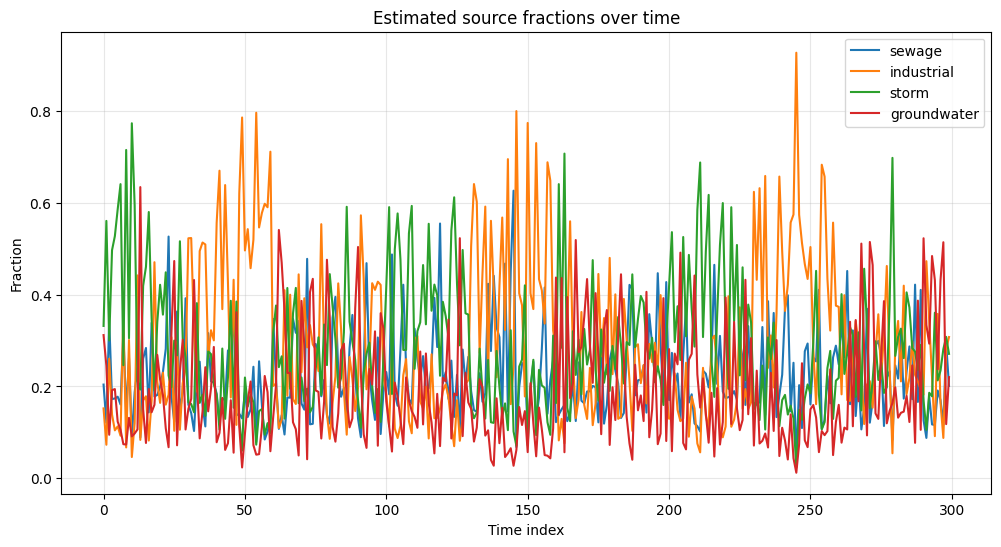

Event distribution: dry_weather         120
first_flush          90
industrial_spike     90
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
for src in sources:
    plt.plot(estimated_fractions_df[src], label=src, linewidth=1.5)
plt.legend()
plt.title("Estimated source fractions over time")
plt.xlabel("Time index")
plt.ylabel("Fraction")
plt.grid(True, alpha=0.3)
plt.show()

# Quick view of event regimes vs fractions (first 100 points)
events = fractions_df["event"].tolist()
print("Event distribution:", pd.Series(events).value_counts())
